# Localizações perdidas - Kaggle

Competição Kaggle da turma de Mineração de Dados 02/2018. 
URL: https://www.kaggle.com/c/dmufmg20182

Análise: Bruno Santos Machado - mr.carax@gmail.com

# Carregando bibliotecas

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math
from sklearn.cluster import KMeans

FLAG_CARREGAR_FALTANTES_PREENCHIDOS = False

# Definição dos métodos

In [37]:
#Vasculhara todas as linhas do dataset procurando nas colunas
#que indicam os ids dos amigos presentes no momento do post.
#Naturalmente, indica se o id indicado estava presente
#com algum colega que originou o post.

#retorno: True/False, coordenada lat e long
def procura_id(id, dataset):
    
    #Existem usuarios que estao estao 2 ou mais lugares ao mesmo tempo
    #Por exemplo, usuario X posta uma mensagem dizendo que o usuario A 
    #esta com ele. No entanto, o usuario Y tambem posta uma mensagem NO
    #MESMO INSTANTE e diz que o usuario A tambem esta com ele.
    #Vale dizer que A e B nao estao na mesma coordenada geografica
    qtde_resultados_encontrado = 0 
    resultado = {"encontrado": False, "coordenadas":[0,0]}
    
    for indice,x in dataset.iterrows():

        if(
          (x['a']==id) | 
          (x['b']==id) |
          (x['c']==id) |
          (x['d']==id) |
          (x['e']==id) |
          (x['f']==id) |
          (x['g']==id) |
          (x['h']==id) |
          (x['i']==id)):
            
            qtde_resultados_encontrado = qtde_resultados_encontrado + 1
 
            if(qtde_resultados_encontrado>1):
                break #encontrou mais de 1 posicao do usuario id. Saia do loop e nao retorne resultado.

            if(qtde_resultados_encontrado==1): #se achar somente 1 resultado, entao OK!
                resultado = {"encontrado": True, "coordenadas": [x['gps_lat'], x['gps_long']]}
        
    return resultado



#Metodo que calculará a distância média entre 3 pontos definidos no Overview da competição.

#latitude,longitude
#ponto 1: 0,0
#ponto 2: 999,0
#ponto 3: 450,999
def distancia_media(p_lat, p_long):
    p1_lat = 0.0
    p1_long = 0.0
    
    p2_lat = 0.0
    p2_long = 999.0
    
    p3_lat = 999.0
    p3_long = 450.0
    
    distanciaA = math.sqrt((p_lat-p1_lat)**2 + (p_long-p1_long)**2)
    distanciaB = math.sqrt((p_lat-p2_lat)**2 + (p_long-p2_long)**2)
    distanciaC = math.sqrt((p_lat-p3_lat)**2 + (p_long-p3_long)**2)
    
    return ((distanciaA + distanciaB + distanciaC)/3.0)

# Carregando os datasets

- fullfile_allsers_formatado_train:
    * contendo as mensagens dos usuários que sabemos a localização com seu respectivo horário;


- mensagens 
    * Informações sobre o número de mensagens.
        (1) número de mensagens observadas
        (2) número de mensagens perdidas
        (3) número de usuários da rede 


- faltantes 
    * Informa quais são os usuários que perderam mensagens na rede.  
        (1) o id do usuário seguido da ordem cronológica das perdas 
        (2) a data de perda da mensagem, assim como descrita no Overview.

In [3]:
dataset_faltantes = pd.read_csv('faltantes', sep=" ", names=['id_usuario','data_original','gps_lat','gps_long'])
dataset_mensagens = pd.read_csv('mensagens', sep=" ", names=['nro_msgs_observadas','nro_usuarios','nro_msgs_perdidas'])   

# Análise do dataset "faltantes"

In [4]:
print("Quantidade de mensagens faltantes: ", dataset_faltantes.count()[0])

Quantidade de mensagens faltantes:  83224


In [5]:
#Visualizando estrutura da tabela.
dataset_faltantes.head()

,id_usuario,data_original,gps_lat,gps_long
0,1000,05/01/2100/01/20/38,NaN,NaN
1,1000,10/01/2100/01/20/38,NaN,NaN
2,1000,16/01/2100/01/20/38,NaN,NaN
3,1000,04/01/2100/13/01/32,NaN,NaN
4,1000,04/01/2100/21/49/39,NaN,NaN


In [6]:
dataset_faltantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83224 entries, 0 to 83223
Data columns (total 4 columns):
id_usuario       83224 non-null int64
data_original    83224 non-null object
gps_lat          0 non-null float64
gps_long         0 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.5+ MB


In [7]:
dataset_mensagens

,nro_msgs_observadas,nro_usuarios,nro_msgs_perdidas
0,747866,1240,83224


# Carregando dataset principal

In [8]:
#Esquema do arquivo fullfile_allusers_formatado_train
#(1) - ID da mensagem;
#(2) - ID do usuário que posta a mensagem;
#(3) - Localização geográfica da informação (latitude e longitude);
#(4) - Data da postagem (dia/mês/ano/horas/minutos/segundos);
#(5) - Lista de IDs de usuários que estavam juntos na hora da postagem.
df = pd.read_csv('fullfile_allusers_formatado_train', sep = " ",
                    names=['id_usuario','gps_lat','gps_long','data_original','a','b','c','d','e', 'f', 'g','h','i'])

In [9]:
df = df.fillna(0) #preenchendo o valores nulos com zero

#convertendo as colunas com IDs de usuario de float para int
df.a = df.a.astype(int) 
df.b = df.b.astype(int)
df.c = df.c.astype(int)
df.d = df.d.astype(int)
df.e = df.e.astype(int)
df.f = df.f.astype(int)
df.g = df.g.astype(int)
df.h = df.h.astype(int)
df.i = df.i.astype(int)

df.head(8)

,id_usuario,gps_lat,gps_long,data_original,a,b,c,d,e,f,g,h,i
0,1000,-15.4138,10.7847,03/01/2100/01/20/38,3,0,0,0,0,0,0,0,0
1,1000,-13.3703,15.8038,04/01/2100/01/20/38,3,5,15,19,21,23,0,0,0
2,1000,-13.2054,21.1433,06/01/2100/01/20/38,3,5,15,19,0,0,0,0,0
3,1000,-17.9668,13.7384,07/01/2100/01/20/38,7,0,0,0,0,0,0,0,0
4,1000,-14.3203,21.2333,08/01/2100/01/20/38,3,5,13,15,19,21,23,25,27
5,1000,-11.1863,11.0989,09/01/2100/01/20/38,3,5,7,13,15,0,0,0,0
6,1000,-16.0988,20.3874,11/01/2100/01/20/38,5,15,17,19,23,27,0,0,0
7,1000,-13.4527,16.3505,12/01/2100/01/20/38,3,5,15,19,21,23,25,27,29


# Conversão funcional da data e horário. Indexação dos registros por ordem cronológica

In [10]:
df['data']= pd.to_datetime(df['data_original'], format="%d/%m/%Y/%H/%M/%S")

In [11]:
df['hora'] = df['data'].dt.strftime("%H:%M:%S")

In [12]:
df.head()

,id_usuario,gps_lat,gps_long,data_original,a,b,c,d,e,f,g,h,i,data,hora
0,1000,-15.4138,10.7847,03/01/2100/01/20/38,3,0,0,0,0,0,0,0,0,2100-01-03 01:20:38,01:20:38
1,1000,-13.3703,15.8038,04/01/2100/01/20/38,3,5,15,19,21,23,0,0,0,2100-01-04 01:20:38,01:20:38
2,1000,-13.2054,21.1433,06/01/2100/01/20/38,3,5,15,19,0,0,0,0,0,2100-01-06 01:20:38,01:20:38
3,1000,-17.9668,13.7384,07/01/2100/01/20/38,7,0,0,0,0,0,0,0,0,2100-01-07 01:20:38,01:20:38
4,1000,-14.3203,21.2333,08/01/2100/01/20/38,3,5,13,15,19,21,23,25,27,2100-01-08 01:20:38,01:20:38


In [13]:
#Suprimindo a coluna data_original e indexando pelo campo data
df = df.drop(columns='data_original')
df = df.sort_values(by=['data'])

In [14]:
dataset_faltantes['data']= pd.to_datetime(dataset_faltantes['data_original'], format="%d/%m/%Y/%H/%M/%S")

In [15]:
dataset_faltantes['hora'] = dataset_faltantes['data'].dt.strftime("%H:%M:%S")

In [16]:
#Suprimindo a coluna data_original após a criação da coluna 'data' e 'hora'
dataset_faltantes = dataset_faltantes.drop(columns='data_original')

In [17]:
dataset_faltantes.head(5)

,id_usuario,gps_lat,gps_long,data,hora
0,1000,NaN,NaN,2100-01-05 01:20:38,01:20:38
1,1000,NaN,NaN,2100-01-10 01:20:38,01:20:38
2,1000,NaN,NaN,2100-01-16 01:20:38,01:20:38
3,1000,NaN,NaN,2100-01-04 13:01:32,13:01:32
4,1000,NaN,NaN,2100-01-04 21:49:39,21:49:39


Text(0.5,1,'GRAFICO 01 - QUANTIDADE DE REGISTROS DO DATASET ORIGINAL FILTRADO PELO ID DO USUÁRIO')

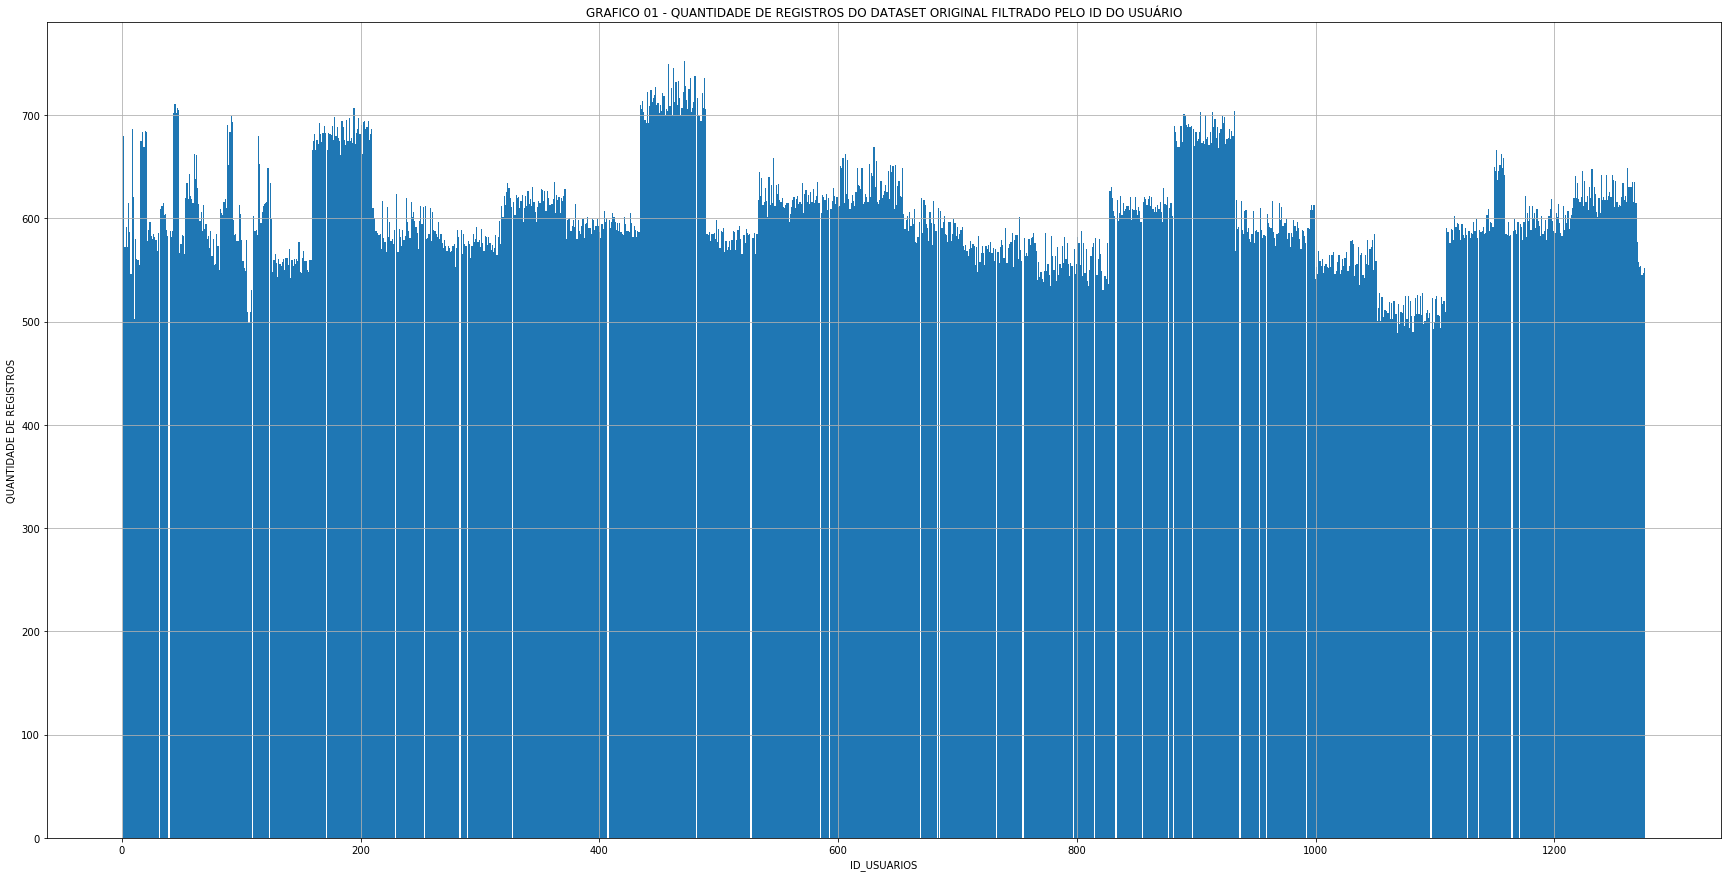

In [18]:
#Visualizando a quantidade de registros de acordo com o id_usuario.

# Analise gráfica

# Observa-se uma quantidade de 600 registros médios por ID de usuário.
# Pode-se inferir também pela visualização que existem IDs inexistentes
# no range de 1 a 1276 (ID máximo de usuário). As lacunas em branco indicam
# a posição de IDs que não apresentam nenhum registro.

plt.figure(figsize=(30,15))
graf_01 = df['id_usuario'].hist(bins=1276)
graf_01.set_ylabel("QUANTIDADE DE REGISTROS")
graf_01.set_xlabel("ID_USUARIOS")
graf_01.set_title("GRAFICO 01 - QUANTIDADE DE REGISTROS DO DATASET ORIGINAL FILTRADO PELO ID DO USUÁRIO")

# Análise do dataset principal

De acordo com o método describe executado no bloco acima, temos as seguintes informações:
    
    * 747.866 registros
    
    * Usuários:
        - ID mínimo: 1 
        - ID máximo: 1276
        
    * Mínimos e máximos das colunas de latitude e longitude apresentam sérias distorções  
    
    * Dos 747.866 registros, temos que estavam presentes no mesmo momento:
        
        - 037.365: responsável pelo registro estava sozinho
        - 710.501: responsável pelo registro + 1 pessoa
        - 561.109: responsável pelo registro + 2 pessoas
        - 485.927: responsável pelo registro + 3 pessoas
        - 413.437: responsável pelo registro + 4 pessoas
        - 342.098: responsável pelo registro + 5 pessoas
        - 274.410: responsável pelo registro + 6 pessoas
        - 201.630: responsável pelo registro + 7 pessoas
        - 132.960: responsável pelo registro + 8 pessoas
        - 065.053: responsável pelo registro + 9 pessoas
      
      Abaixo, estes números estão representados num gráfico:


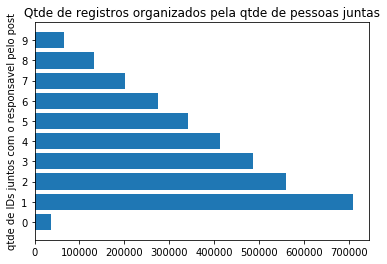

<Figure size 2160x1080 with 0 Axes>

In [19]:
nro_pessoas = {'usuarios': ['0','1','2','3','4','5','6','7','8','9'],
    'qtd': [37365,710501,561109,485927,413437,342098,274410,201630,132960,65053]}

df_nro_pessoas = pd.DataFrame(nro_pessoas,columns=['usuarios','qtd'])#, columns=['usuarios_juntos','quantidade'])
fig_00, ax_00 = plt.subplots()
ax_00.set_ylabel('qtde de IDs juntos com o responsavel pelo post')
ax_00.set_title('Qtde de registros organizados pela qtde de pessoas juntas')
ax_00.barh(df_nro_pessoas['usuarios'],df_nro_pessoas['qtd'])
fig_00 = plt.figure(figsize=(30,15))

# Observações sobre as coordenadas geográficas

As informações de latitude e longitude estão
com registros de valores absolutos colossais da ordem de 10^15.
Tais registros precisam de uma análise especial.

Geograficamente, a latitude poderá variar unicamente entre -90 graus (SUL) e +90 graus (NORTE).
Já a longitude varia entre -180 (OESTE) e +180(LESTE). 

Consideraremos o limite como 1000 graus (tanto positivo como negativo) pois as
posições de referência para o cálculo das distâncias finais possuem coordenadas
que atingem o valor de 999 graus.

Valores que extrapolem estes limites serão considerados inconsistentes. A instrução
abaixo seleciona estes dados e os armazena no DataFrame df_gps_invalido.

In [20]:
#Selecionando os registros que extrapolam 1000 graus.
df_gps_ruido = pd.DataFrame(df[  (df['gps_lat']>1000) | (df['gps_lat']<-1000)  |  (df['gps_long']<-1000) | (df['gps_long']>1000) ] )

In [21]:
print("Quantidade de registros com ruídos nas coordenadas geográficas: ", df_gps_ruido.count()[0])

Quantidade de registros com ruídos nas coordenadas geográficas:  119548


In [22]:
#Exclusão dos registros do dataframe principal:
df = df.drop(df_gps_ruido.index)

# GRAFICO 01 - registros excluídos do dataset por terem coordenadas que extrapolam o limite de 1000 graus.

Text(0.5,1,'GRAFICO 01 - QUANTIDADE DE REGISTROS DO DATASET ORIGINAL FILTRADO PELO ID DO USUÁRIO')

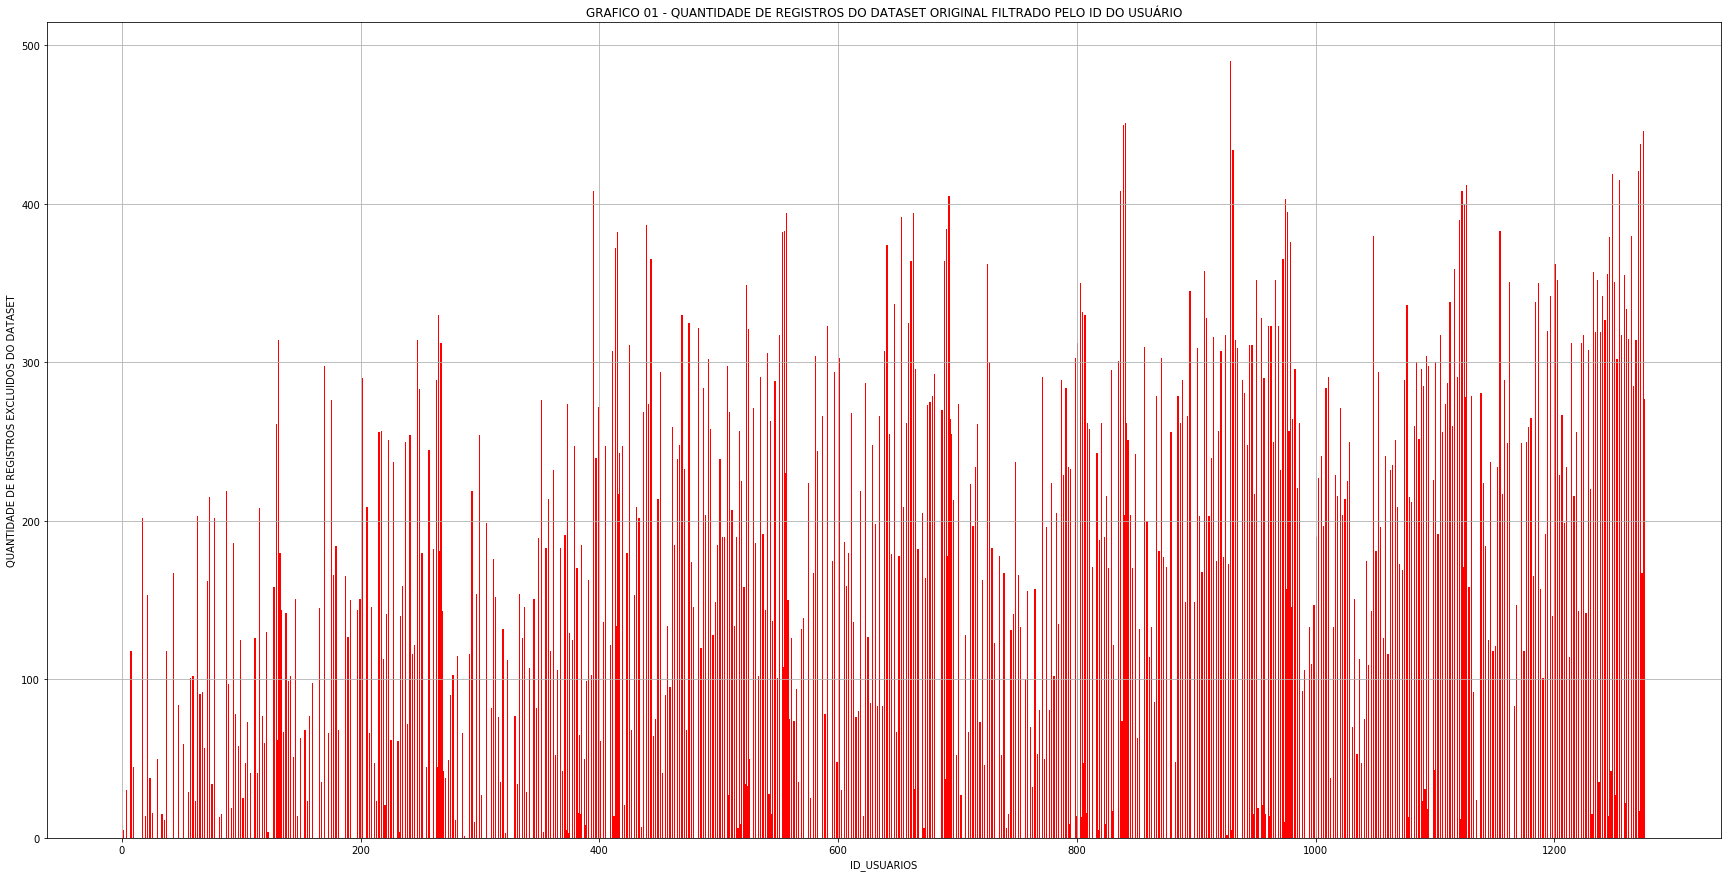

In [24]:
plt.figure(figsize=(30,15))
graf_001 = df_gps_ruido['id_usuario'].hist(bins=1276,color='red')
graf_001.set_ylabel("QUANTIDADE DE REGISTROS EXCLUIDOS DO DATASET")
graf_001.set_xlabel("ID_USUARIOS")
graf_001.set_title("GRAFICO 01 - QUANTIDADE DE REGISTROS DO DATASET ORIGINAL FILTRADO PELO ID DO USUÁRIO")

# Gráfico 02 - 628.318 registros com posições geográficas válidas

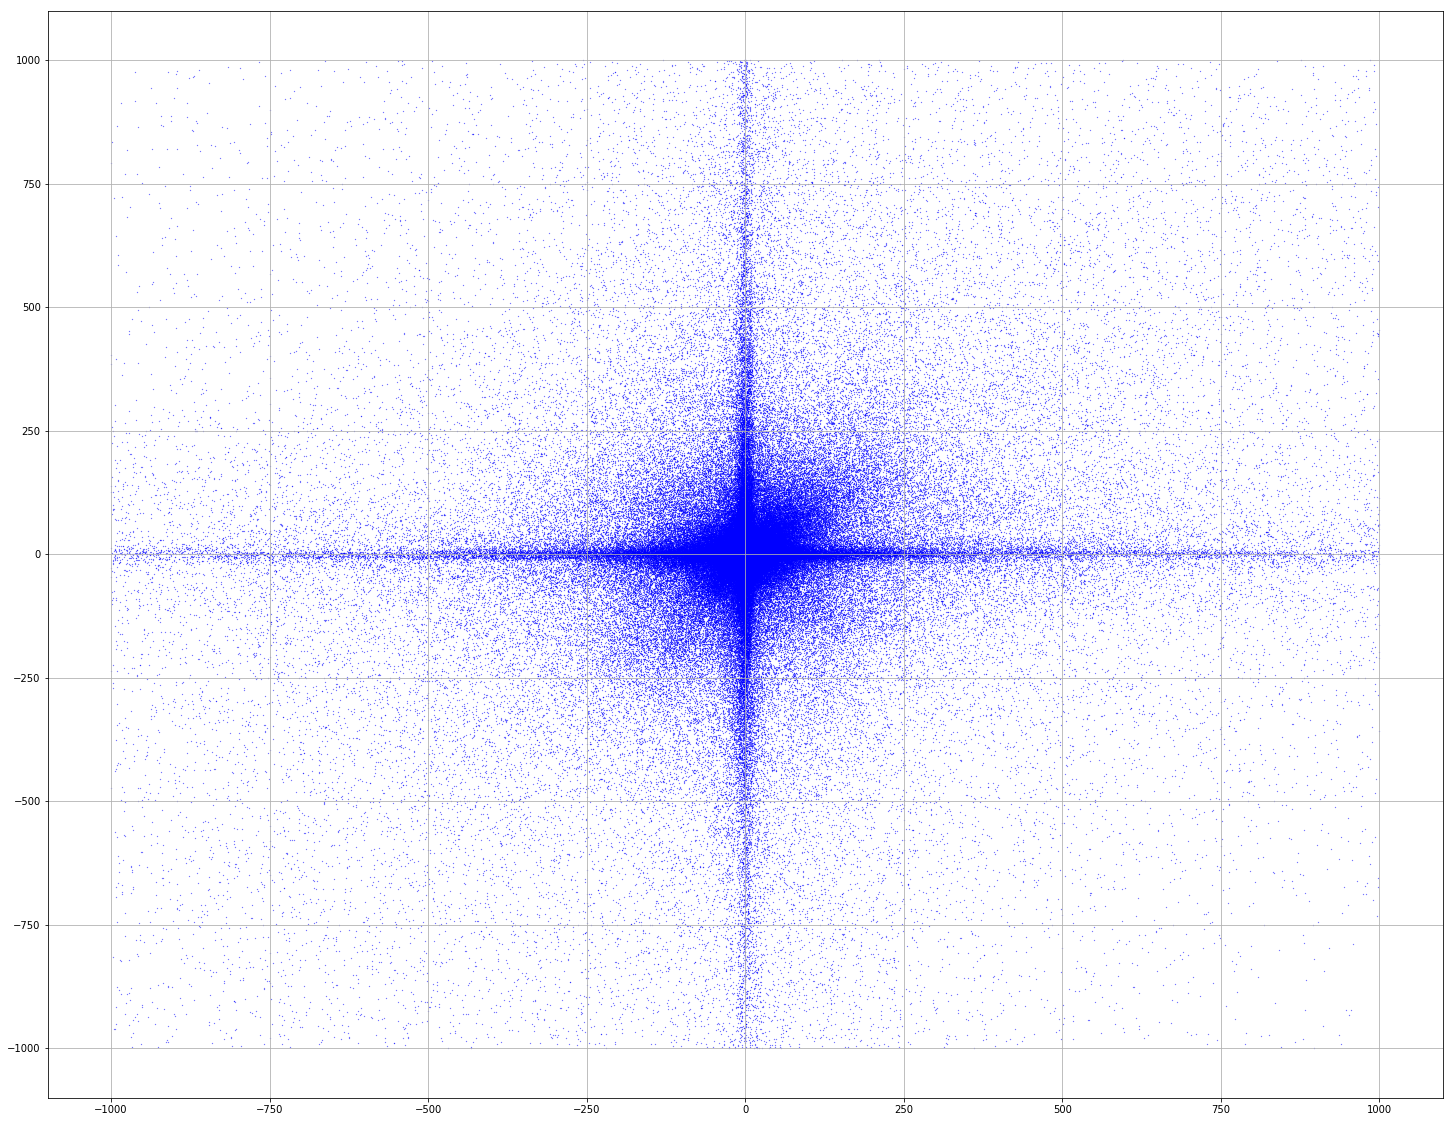

In [26]:
plt.figure(figsize=(25,20))
graf_02 = plt.scatter(df['gps_long'],df['gps_lat'],s=0.05,c='blue')
plt.grid(True)

# GRÁFICO 03 - Quantidade de registros válidos de acordo com o ID do usuário

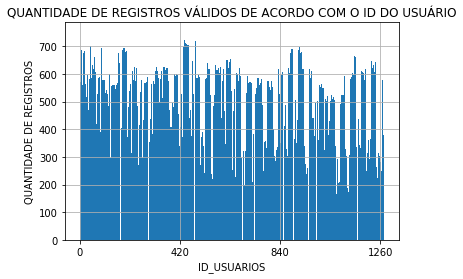

In [27]:
#Visualizando a quantidade de registros VÁLIDOS de acordo com o id_usuario.
fig_02, ax_02 = plt.subplots()
ax_02 = df['id_usuario'].hist(bins=1276)
ax_02.grid(zorder=0)
ax_02.set_ylabel("QUANTIDADE DE REGISTROS")
ax_02.set_xlabel("ID_USUARIOS")
ax_02.set_title("QUANTIDADE DE REGISTROS VÁLIDOS DE ACORDO COM O ID DO USUÁRIO")
ax_02.set_xticks(np.arange(0,1278,420))

# GRÁFICO 04 - Quantidade de registros COM RUÍDO de acordo com o ID do usuário

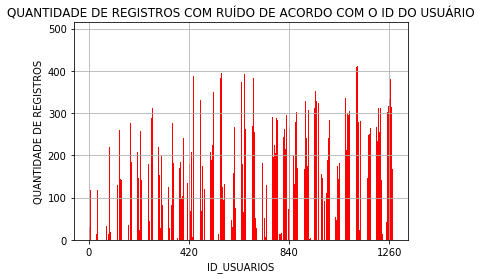

In [28]:
fig_04, ax_04 = plt.subplots()
ax_04 = df_gps_ruido['id_usuario'].hist(bins=1276,color='red')
ax_04.set_ylabel("QUANTIDADE DE REGISTROS")
ax_04.set_xlabel("ID_USUARIOS")
ax_04.set_title("QUANTIDADE DE REGISTROS COM RUÍDO DE ACORDO COM O ID DO USUÁRIO")
ax_04.set_xticks(np.arange(0,1278,420))

In [29]:
df_gps_ruido.head()

,id_usuario,gps_lat,gps_long,a,b,c,d,e,f,g,h,i,data,hora
597540,769,-4.05392,34450.90,3,4,5,6,7,8,9,10,11,2100-01-02 05:28:05,05:28:05
609760,789,31.37290,-3681.61,1,3,0,0,0,0,0,0,0,2100-01-02 05:28:05,05:28:05
601425,775,2831.17000,1153.49,805,1124,1177,0,0,0,0,0,0,2100-01-02 05:28:05,05:28:05
630513,823,87.35180,-1118.09,9,27,47,83,89,91,0,0,0,2100-01-02 05:28:05,05:28:05
611455,791,18101.60000,-273253.00,0,0,0,0,0,0,0,0,0,2100-01-02 05:28:05,05:28:05


# GRAFICO 05 - registros que precisam ter sua posição identificada

Text(0.5,1,'QUANTIDADE DE REGISTROS FALTANTES DE ACORDO COM O ID DO USUÁRIO')

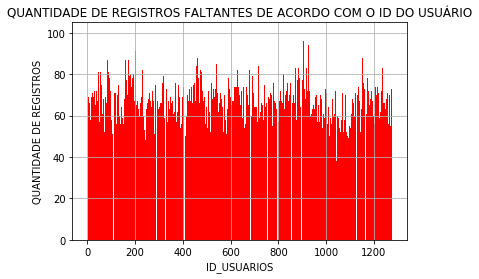

In [31]:
graf_05 = dataset_faltantes['id_usuario'].hist(bins=1276,color='red')
graf_05.set_ylabel("QUANTIDADE DE REGISTROS")
graf_05.set_xlabel("ID_USUARIOS")
graf_05.set_title("QUANTIDADE DE REGISTROS FALTANTES DE ACORDO COM O ID DO USUÁRIO")

# GRÁFICO 06 - Rota do id_usuário=794

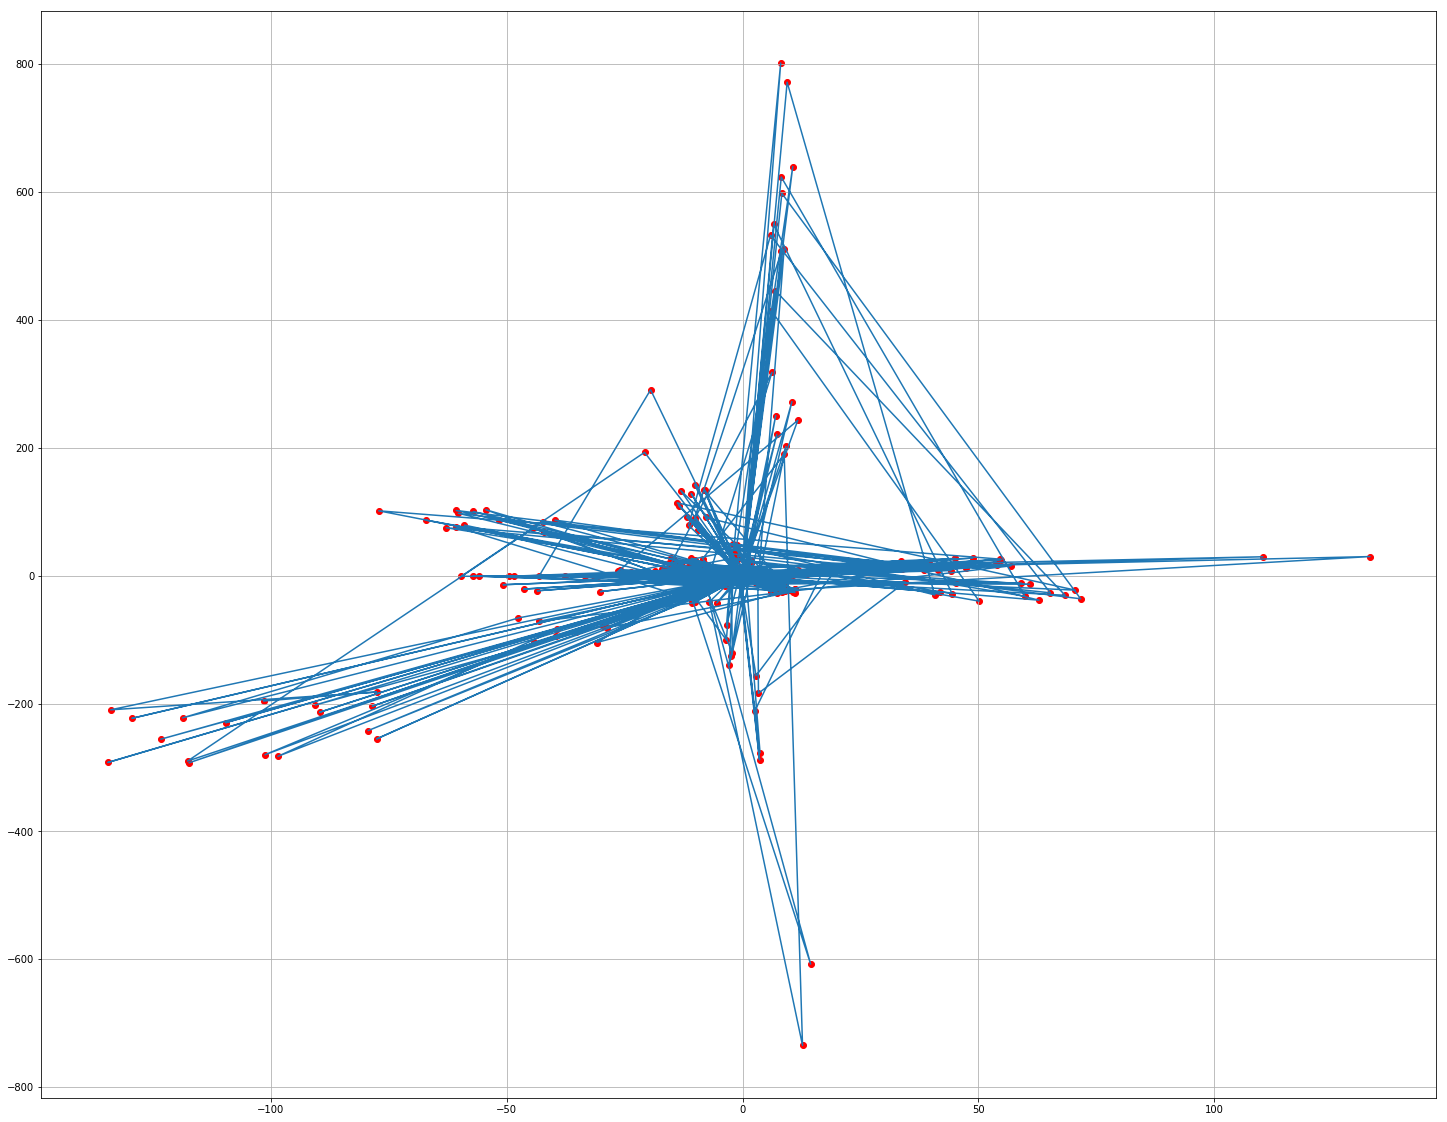

In [32]:
#Representa toda a movimentação do usuário 794 em ordem cronológica
df_usuario = df[df['id_usuario']==794]
plt.figure(figsize=(25,20))
graf_06 = plt.plot(df_usuario['gps_long'],df_usuario['gps_lat'])
graf_06 = plt.scatter(df_usuario['gps_long'],df_usuario['gps_lat'],c='red')
plt.grid(True)

# GRÁFICO 07 - Registros faltantes distribuídos pelas 24h do dia

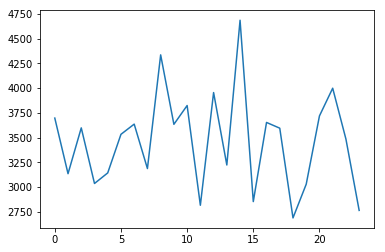

In [33]:
#Quantidade total de registros faltantes agrupados pela HORA.
dataset_faltantes_horas = dataset_faltantes.set_index(pd.DatetimeIndex(dataset_faltantes['data']))
dataset_faltantes_horas = dataset_faltantes_horas.groupby(dataset_faltantes_horas.index.hour).count()['data']
plt.plot(dataset_faltantes_horas.index, dataset_faltantes_horas)

# Definindo posição de IDs de acordo com o post de um segundo ID que acusou a presença do primeiro

O bloco abaixo toma cerca de 30 minutos de execução

In [39]:
#ITERANDO CADA UM DOS REGISTROS FALTANTES
i=-1
for indice, registro_faltante in dataset_faltantes.iterrows():
    i=i+1
    if(i%5000==0): #para mostrar a evolucao da execucao do loop. A cada 5000 registros, imprima mensagem.
        print(i, " registros analisados")

    usuario_faltante = registro_faltante['id_usuario']
    data_faltante = registro_faltante['data']
    hora_faltante = registro_faltante['hora']

    #Selecionando TODOS os registros válidos da data/hora em questao
    df_validos_do_horario = pd.DataFrame(df[(df['data']==data_faltante)])

    resposta = procura_id(usuario_faltante, df_validos_do_horario)

    if(resposta['encontrado']==True):
            
        #Atualiza coordenadas do dataset_faltantes
        dataset_faltantes.gps_lat.iloc[indice] = resposta['coordenadas'][0]
        dataset_faltantes.gps_long.iloc[indice] = resposta['coordenadas'][1]

0  registros analisados


/Users/pinguim/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


5000  registros analisados
10000  registros analisados
15000  registros analisados
20000  registros analisados
25000  registros analisados
30000  registros analisados
35000  registros analisados
40000  registros analisados
45000  registros analisados
50000  registros analisados
55000  registros analisados
60000  registros analisados
65000  registros analisados
70000  registros analisados
75000  registros analisados
80000  registros analisados


# APLICANDO K-MEANS

O bloco abaixo toma por volta de 20 minutos de execução.

In [40]:
contador = 0 

#Análise de registro por registro do dataset de registros faltantes.
#K-Means será utilizado para definir o centróide de um grupo de pontos.
for indice,registro in dataset_faltantes.iterrows():

    if(contador%5000==0):
        print(contador, "avaliados")
    
    contador = contador+1
       
    #A posicao geografica do registro já poderá ter sido
    #atualizada em virtude de algum registro anterior com o mesmo horário que, porventura,
    #tenha sido analisado. Como o update é realizado para todos os registros do horário Y de um 
    #usuário, então existe esta possibilidade. Enfim, se a coordenada geográfica
    #já estiver definida, então podemos pular o registro e continuar a iteração.
    if(math.isnan(registro['gps_lat']) == False):
        continue
    
    #Seleciona TODOS os registros validos do usuario registro['id_usuario']
    df_usuario_reg_validos = df[(df['id_usuario']==registro['id_usuario']) ]
        
    #Indexação pelo campo 'data'
    df_usuario_reg_validos = df_usuario_reg_validos.set_index(pd.DatetimeIndex(df_usuario_reg_validos['data']))
    
    #Selecionando todos os registros faltantes do usuario
    df_usuario_reg_faltantes = dataset_faltantes[(dataset_faltantes['id_usuario']==registro['id_usuario'])]
            
    #Selecionando os registros faltantes de um horário específico
    df_usuario_reg_horario = df_usuario_reg_validos.loc[df_usuario_reg_validos['data'].between_time(registro['hora'],registro['hora'])]
    
    #Separando as coordenadas para treinamento do K-Means
    X = df_usuario_reg_horario.iloc[:, [1,2]].values
    
    #Poderão existir horários de registros faltantes do usuário X que não serão
    #encontrados nos registros válidos. Assim, teremos que seguir em frente e 
    #pesquisar um outro método para prever a posição. Se isso acontecer, então,
    #desconsidere o registro faltante e siga em frente na iteração.
    if(X.size==0):
        continue
    
    kmeans = KMeans(n_clusters = 1, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    y_means = kmeans.fit_predict(X)
    
    #Armazenando os centroides nos registros faltantes
    dataset_faltantes.loc[(dataset_faltantes['id_usuario']==registro['id_usuario']) & (dataset_faltantes['hora']==registro['hora']) , 'gps_lat'] = kmeans.cluster_centers_[:,0]
    dataset_faltantes.loc[(dataset_faltantes['id_usuario']==registro['id_usuario']) & (dataset_faltantes['hora']==registro['hora']) , 'gps_long'] = kmeans.cluster_centers_[:,1]

5000 avaliados
10000 avaliados
15000 avaliados
20000 avaliados
25000 avaliados
30000 avaliados
35000 avaliados
40000 avaliados
45000 avaliados
50000 avaliados
55000 avaliados
60000 avaliados
65000 avaliados
70000 avaliados
75000 avaliados
80000 avaliados


# Gráfico 08 - Visualizando centróide de um grupo de registros

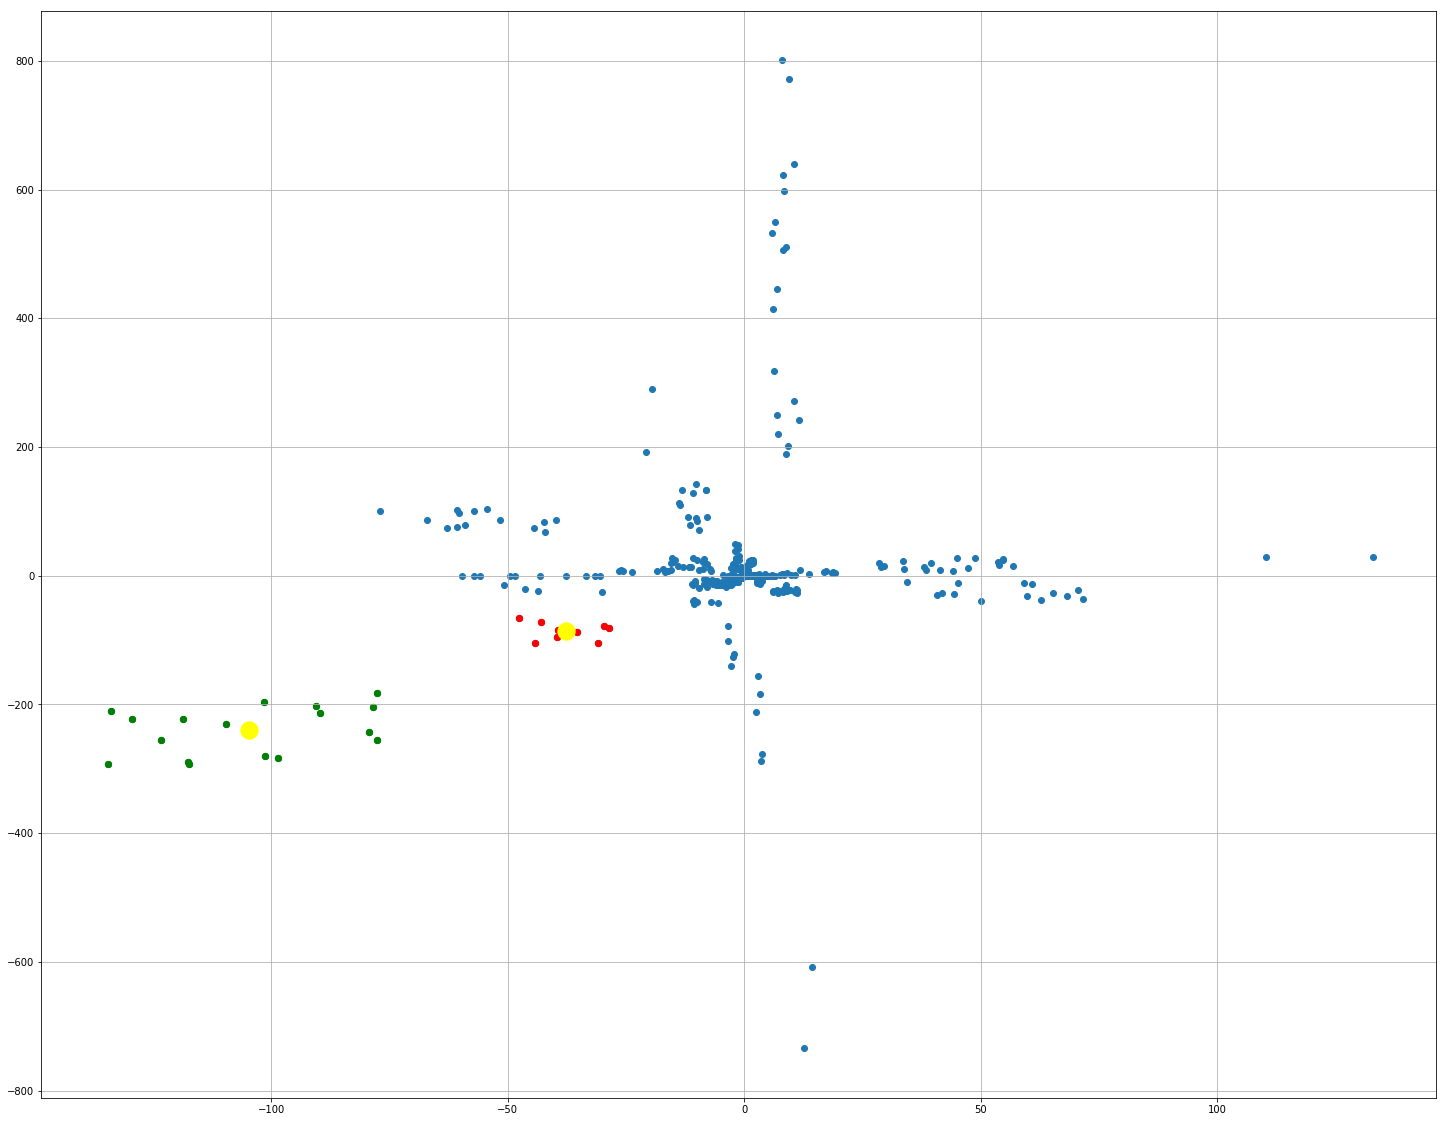

In [44]:
#Gráfico apresenta dois grupos. Estao agrupados de acordo com o horário do registro do usuário 794.
# primeiro grupo: 21:13:22
# segundo grupo: 10:57:05
# O ponto AMARELO definirá o centróide de cada um dos grupos.

df_usuario_reg_validos = df[(df['id_usuario']==794) ]
df_usuario_reg_validos = df_usuario_reg_validos.set_index(pd.DatetimeIndex(df_usuario_reg_validos['data']))
df_usuario_reg_horario = df_usuario_reg_validos.loc[df_usuario_reg_validos['data'].between_time('21:13:22','21:13:22')]
df_usuario_reg_horario_2 = df_usuario_reg_validos.loc[df_usuario_reg_validos['data'].between_time('10:57:05','10:57:05')]

plt.figure(figsize=(25,20))
graf_08 = plt.scatter(df_usuario_reg_validos['gps_long'],df_usuario_reg_validos['gps_lat'])
graf_08 = plt.scatter(df_usuario_reg_horario['gps_long'],df_usuario_reg_horario['gps_lat'],s=40,c='green')
graf_08 = plt.scatter(df_usuario_reg_horario_2['gps_long'],df_usuario_reg_horario_2['gps_lat'],s=40,c='red')

X = df_usuario_reg_horario.iloc[:, [1,2]].values
X2 = df_usuario_reg_horario_2.iloc[:, [1,2]].values

#De acordo com a posicao planetaria, a longitude equivale ao eixo cartesiano horizontal e a latitude a vertical.
#eixo X - longitude
#eixo Y - latitude
#Por isso invertemos abaixo. Primeiro o [:,1], depois o [:,0]
kmeans = KMeans(n_clusters = 1, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = kmeans.fit_predict(X)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0],s=300, c='yellow')

y_means = kmeans.fit_predict(X2)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0],s=300, c='yellow')
plt.grid(True)
plt.show()

# Exportando arquivo de saída

Arquivo de saída armazenará o ID do usuário, o número do registro e sua respectiva distância média aos três pontos definidos na proposta.

In [46]:
file = open('saida.txt','w+') 
file.write('ID,Value\n')

for indice,registro in dataset_faltantes.iterrows():
    
    if(math.isnan(registro['gps_lat']) == True): #se nao houver coordenada, iguale a distancia a 0
        distancia = 0.0
    else:
        distancia = distancia_media(registro['gps_lat'], registro['gps_long'])
    
    #some 1 ao indice. A tabela tem que comecar a partir do 1 e nao do zero.
    frase= str(registro['id_usuario'])+":"+ str(indice+1) + "," + str(distancia)+"\n"
    
    file.write(frase) 

file.close()